In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from pathlib import Path
from torchvision import transforms as T
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import cv2
import matplotlib.patches as patches

In [404]:
import os
import pandas as pd
from torchvision.io import read_image
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y']
class HandSignDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.img_labels = []
        self.path = []
        for letter in alphabet:
            for idx, image in enumerate(os.listdir(img_dir +'\\' + letter)):
                self.img_labels.append(letter)
                self.path.append(image)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir + '\\' + self.path[idx][-5] + '\\' + self.path[idx]
        image = read_image(img_path)
        image = np.stack((image.reshape((28,28)),)*3)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [405]:
train_path = str(Path.cwd() / "HandSigns\Train")
test_path = str(Path.cwd() / "HandSigns\Test")


In [406]:
from torchvision.transforms import Compose
transform = Compose([T.ToTensor()])

example_dataset = HandSignDataset(train_path, transform)
print('The number of samples in the exapmle dataset is ' + str(len(example_dataset)))
print('The label of the second sample in exapmle dataset is ' + str(example_dataset[1][1]))

The number of samples in the exapmle dataset is 27455
The label of the second sample in exapmle dataset is A


In [407]:
batchSize = 64
imageSize = 28
numberOfWorkers = 0
transform = Compose([T.Resize([imageSize,imageSize]),  T.ToTensor()])
dataset_val = HandSignDataset(test_path, transform)
dataset_train = HandSignDataset(train_path, transform)
dataset_test = HandSignDataset(test_path,imageSize)
train_dataloader = DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=numberOfWorkers)
val_dataloader = DataLoader(dataset_val, batch_size=batchSize, shuffle=True, num_workers=numberOfWorkers)
test_dataloader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True, num_workers=numberOfWorkers)

In [528]:
maxpool_size = 2
strideLength = 1
class HandCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=strideLength, padding=0)
        self.mp = nn.MaxPool2d(kernel_size=[maxpool_size,maxpool_size], stride=2)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=strideLength, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=strideLength, padding=0)
        self.bn = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, len(alphabet))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_batch):       
        x = self.conv1(input_batch)
        x = self.relu(x)
        x = self.mp(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.mp(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.mp(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)
        x = self.softmax(x)
        x = x.squeeze(1)
        
        return x


In [409]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    device = "cpu"
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, xy_tupel in enumerate(train_loader, 1):
        y = []
        for element in xy_tupel[1]:
            letterToVector = np.zeros(len(alphabet))
            letterToVector[alphabet.index(element)] = 1
            y.append(letterToVector)
        x = xy_tupel[0]/255
        y = torch.tensor(y)
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs).to(device)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        numberOfCorrect = 0
        for indx, element in enumerate(z):
            predictedLetter = torch.argmax(element)
            trueLetter = torch.argmax(y[indx])
            if predictedLetter == trueLetter:
                numberOfCorrect += 1
            
        acc_batch_avg = numberOfCorrect/len(y)

        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, xy_tupel in enumerate(val_loader, 1):
            y = []
            for element in xy_tupel[1]:
                letterToVector = np.zeros(len(alphabet))
                letterToVector[alphabet.index(element)] = 1
                y.append(letterToVector)
            x = xy_tupel[0]/255
            y = torch.tensor(y)
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs).to(device)
            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()

            numberOfCorrect = 0
            for indx, element in enumerate(z):
                predictedLetter = torch.argmax(element)
                trueLetter = torch.argmax(y[indx])
                if predictedLetter == trueLetter:
                    numberOfCorrect += 1
            
            acc_batch_avg = numberOfCorrect/len(y)

            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [530]:
loadModel = False
if loadModel:
    model = HandCnn()
    model.load_state_dict(torch.load("HandCnn"))
else:
    numberOfEpochs = 50
    model = HandCnn()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, numberOfEpochs, None)
    torch.save(model.state_dict(), "HandCnn")
    

Starting training
Epoch 1/50: Train loss: 3.178, Train acc.: 0.045, Val. loss: 3.176, Val. acc.: 0.092
Epoch 2/50: Train loss: 3.146, Train acc.: 0.102, Val. loss: 3.127, Val. acc.: 0.185
Epoch 3/50: Train loss: 3.074, Train acc.: 0.206, Val. loss: 3.066, Val. acc.: 0.310
Epoch 4/50: Train loss: 2.997, Train acc.: 0.303, Val. loss: 2.994, Val. acc.: 0.360
Epoch 5/50: Train loss: 2.934, Train acc.: 0.370, Val. loss: 2.937, Val. acc.: 0.410
Epoch 6/50: Train loss: 2.881, Train acc.: 0.420, Val. loss: 2.886, Val. acc.: 0.456
Epoch 7/50: Train loss: 2.844, Train acc.: 0.456, Val. loss: 2.848, Val. acc.: 0.498
Epoch 8/50: Train loss: 2.808, Train acc.: 0.491, Val. loss: 2.799, Val. acc.: 0.527
Epoch 9/50: Train loss: 2.777, Train acc.: 0.524, Val. loss: 2.758, Val. acc.: 0.577
Epoch 10/50: Train loss: 2.747, Train acc.: 0.560, Val. loss: 2.711, Val. acc.: 0.637
Epoch 11/50: Train loss: 2.717, Train acc.: 0.588, Val. loss: 2.676, Val. acc.: 0.669
Epoch 12/50: Train loss: 2.694, Train acc.: 0

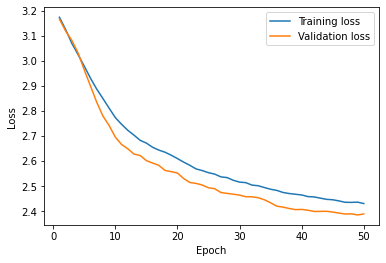

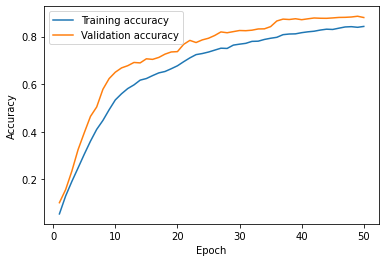

In [523]:
batchesPerEpoch = int(np.ceil(len(dataset_train)/batchSize))
x = np.linspace(batchesPerEpoch, batchesPerEpoch*numberOfEpochs, numberOfEpochs, dtype=np.int32)
epochs = np.linspace(1, numberOfEpochs, numberOfEpochs)
smoothed_train_accs = [np.mean(train_accs[xi-batchesPerEpoch:xi]) for xi in x]

smoothed_train_losses = [np.mean(train_losses[xi-batchesPerEpoch:xi]) for xi in x]
plt.plot(epochs,smoothed_train_losses);
plt.plot(epochs,val_losses)
plt.legend(['Training loss', 'Validation loss']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.savefig('Loss.png')
plt.show();
plt.plot(epochs,smoothed_train_accs);
plt.plot(epochs, val_accs);
plt.legend(['Training accuracy', 'Validation accuracy']);
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.savefig('Acc.png')

Test accuracy of : 0.7348020078081428
Confusion matrix: 


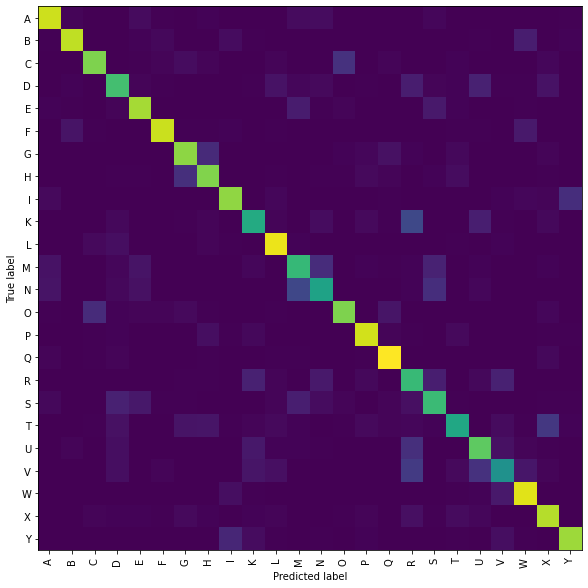

In [527]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
inputs, classes = next(iter(test_dataloader))
 
model = model.to(device)
inputs=inputs.to(device)/255
 
outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()


predLetter = []
numCorrectGuesses = 0
for idx, guess in enumerate(preds):
    predLetter.append(alphabet[guess])
    if predLetter[-1] == classes[idx]:
        numCorrectGuesses +=1
numCorrectGuesses /= len(preds)

print('Test accuracy of : ' + str(numCorrectGuesses))
print('Confusion matrix: ')
cm = confusion_matrix(classes, predLetter)
cm = cm.astype('float64')
for i in range(cm.shape[0]):
    cm[i, :] = cm[i, :] / sum(cm[i, :])
    
plt.figure(figsize=(10, 10));
plt.imshow(cm);
plt.xticks(range(len(alphabet)), alphabet, rotation='vertical');
plt.yticks(range(len(alphabet)), alphabet);
plt.xlabel('Predicted label');
plt.ylabel('True label');
plt.savefig('ConfusionMatrix.png')

Predicted letter: U
Actual letter: H


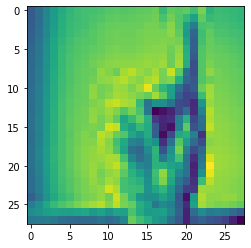

In [511]:
class HandSignDatasetOneImage(Dataset):
    def __init__(self, img_dir, label, transform=None, target_transform=None):
        
        self.img_label = label
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, idx):
        image = read_image(self.img_dir)
        image = np.stack((image.reshape((28,28)),)*3)
        label = self.img_label
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
testimage_path = 'C:\\Users\\Ask\\Desktop\\DML Prodject\\60_K.jpg'
label = 'H'
dataset_testimage = HandSignDatasetOneImage(testimage_path, label)
testimage_dataloader = DataLoader(dataset_testimage, batch_size=1, shuffle=True, num_workers=0)
inputs, classes = next(iter(testimage_dataloader))
model = model.to(device)
inputs=inputs.to(device)/255

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
plt.imshow(plt.imread(testimage_path))
print('Predicted letter: ' + alphabet[int(preds)])
print('Actual letter: ' + classes[0])



Predicted letter: I
Actual letter: I


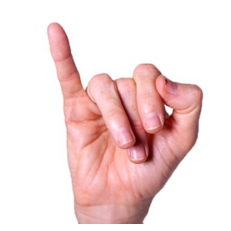

In [514]:
testimage_path = 'C:\\Users\\Ask\\Desktop\\DML Prodject\\I1.jpg'
label = 'I'
image = read_image(testimage_path)/255;
image = Image.open(testimage_path);
image = image.resize((28,28))
transform = Compose([T.PILToTensor()])
image = transform(image)/255
if np.shape(image)[0] != 3:
    image = torch.tensor(np.stack((image.reshape((28,28)),)*3))
image = image.unsqueeze(0);
outputs=model.forward(image)
print('Predicted letter: ' + alphabet[int(torch.argmax(outputs))])
print('Actual letter: ' + label)
plt.imshow(plt.imread(testimage_path));
plt.axis('off');